# Creating a General Purpose Potential for Molecular Crystals - Part 7

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- More tests...

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
import pandas as pd
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames, array_name='forces'):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array(array_name) 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [3]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)

/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.1.0rc1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Compute necessary data and define SOAP

In [4]:
#Compute training, validation and testing data
#Get training data for the FPS-sorted training set
ytF = []
for ifrm, frm in enumerate(train_set_FPS):
    ytF.append(frm.info['energy'])
ytrain_FPS = np.array(ytF)

#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

#Get true energies and forces for test set
ytt = []
ftt = []

for frm in test_set:
    ytt.append(frm.info['energy'])
    ftt.append(frm.get_array('forces'))

ytest_true = np.array(ytt)
ftest_true = np.concatenate(ftt)

#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [5]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Check variance of force predictions for direct and delta model

In part 5 of this notebook, I showed that the variance of forces of DFTB+ - PBE is about half that of PBE on its own. Simulations of succinic acid, benzene and glycine are unstable using the direct PBE potential, but stable using DFTB+ with the PBE0-MBD potential. I will therefore compare the variance of the predicted forces throughout the simulations.

Note that although I'm using the potential trained on PBE0-MBD, the results should still be comparable.

In [19]:
#Import frames 
compound = 'succinic_alpha'
direct = read('/home/vprincip/genMD/PI_NVT_direct/'+compound+'/simulation.frc_00.xyz', ':')
delta = read('/home/vprincip/genMD/PI_NVT_PBE0/'+compound+'/simulation.frc_00.xyz', ':')

In [20]:
#Get forces
direct_frcs = []
delta_frcs = []
for frm in direct:
    direct_frcs.extend(frm.get_positions())
for frm in delta:
    delta_frcs.extend(frm.get_positions())
direct_frcs = np.asarray(direct_frcs).flatten()
delta_frcs = np.asarray(delta_frcs).flatten()

In [21]:
#convert forces from atomic units to eV/angstrom
#note that this is not necessary for comparing variances, but may be useful to compare with other results later
#one a.u. of force is equal to 51.421 eV/angstrom
if np.var(direct_frcs) < 0.1:      #make sure that multiplication doesn't happen again if cell was already run
    direct_frcs = direct_frcs*51.421
if np.var(delta_frcs) < 0.1:
    delta_frcs = delta_frcs*51.421

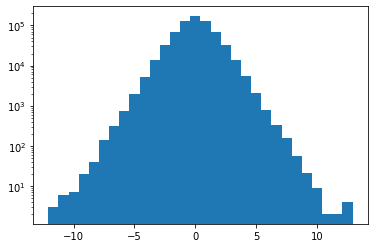

In [22]:
plt.hist(direct_frcs, bins = 30)
plt.yscale('log')

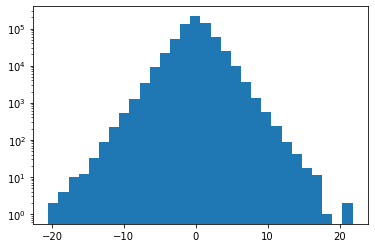

In [23]:
plt.hist(delta_frcs, bins = 30)
plt.yscale('log')

### Check variance of forces using delta PBE-D2 model

In [14]:
#Import frames 
compound = 'succinic_alpha'
direct = read('/home/vprincip/genMD/PI_NVT_direct/'+compound+'/simulation.frc_00.xyz', ':')
delta = read('/home/vprincip/genMD/PI_NVT_PBE_t2/'+compound+'/simulation.frc_00.xyz', ':')

In [24]:
#Get forces
direct_frcs = []
delta_frcs = []
for frm in direct:
    direct_frcs.extend(frm.get_positions())
for frm in delta:
    delta_frcs.extend(frm.get_positions())
direct_frcs = np.asarray(direct_frcs).flatten()
delta_frcs = np.asarray(delta_frcs).flatten()

In [25]:
#convert forces from atomic units to eV/angstrom
#note that this is not necessary for comparing variances, but may be useful to compare with other results later
#one a.u. of force is equal to 51.421 eV/angstrom
if np.var(direct_frcs) < 0.1:      #make sure that multiplication doesn't happen again if cell was already run
    direct_frcs = direct_frcs*51.421
if np.var(delta_frcs) < 0.1:
    delta_frcs = delta_frcs*51.421

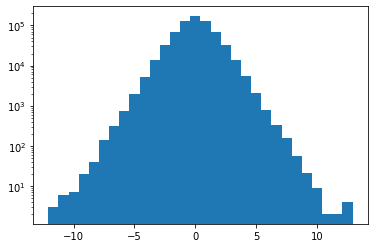

In [26]:
plt.hist(direct_frcs, bins = 30)
plt.yscale('log')

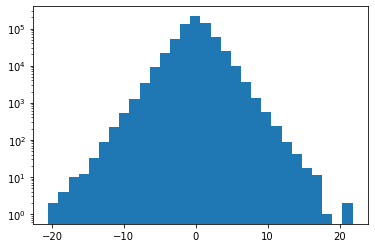

In [27]:
plt.hist(delta_frcs, bins = 30)
plt.yscale('log')

In [28]:
print("Variance of direct force predictions:", np.var(direct_frcs))

2.4229217182373826


In [30]:
print("Variance of delta force predictions:", np.var(delta_frcs))

Variance of delta force predictions: 5.216872867972878


## Create model with a LAMMPS pair potential
As simulations showed certain atoms collapsing in on one another, I will try to create a GAP potential in combination with a LAMMPS pair potential. This LAMMPS pair potential will "correct" force and energy predictions when two atoms come within a certain cutoff. 

From my pair potential + GAP model tutorial, here is why it is necessary:

>When creating your GAP potential, you provide the model with a dataset containing many different configurations and/or systems of interest, hopefully with high fidelity quantum mechanical force and energy data to go along with each snapshot. These snapshots are usually provided from configurational sampling of the system(s) in question. The issue is that these simulations likely did not sample any configurational space where atoms are very close together, as repulsive electrostatic forces should have prevented this from occurring. As the model doesn't know anything about physical principles, it naively extrapolates its model to very small interatomic distances. Instead of having an exponential increase in energy at close distances, with exponentially increasing repulsive forces between the two atoms, it models a decrease in energy/forces down to zero below a certain threshold.

>Now what's the result of this?

>Well, if you subsequently use your GAP potential, and an atom pair pass the aforementioned threshold, the model believes the forces become attractive and the atoms will get cosy and collapse in on each other. Suffice to say the this should definitely not happen in any universe we live in. Hence, we need to compute and execute a parallel potential between pairs of atoms that knows how forces and energies behave at small interatomic distances, and thereby "override" the unphysical predictions of the GAP model.



Using the template in the tutorial, I have already calculated energies and forces of dimers by doing a structure relaxation for each pair, starting from a very short distance. I have then compiled these into a LAMMPS-readable table (called `potential.table` and can be found in the `raw_data/` directory). This potential was used to calculate energies and forces of all frames in the CSD-10k dataset of HCNO structures (2238 crystals x 101 structures per crystal). Results were added to the original dataset and saved as `CSD-10k_combined_w_kpts_pp_results.pickle`, which can again be found in the `raw_data` directory.

### Create dataset with new LAMMPS information

In [6]:
#Import combined dataset
with open('raw_data/CSD-10k_combined_w_kpts_pp_results.pickle', 'rb') as f:
    combined = pickle.load(f)

We now need to match the frames with these pair potential results to the frames in `train_set_FPS` and create a new database. Afterwards, we need to subtract the energies and forces of the LAMMPS potential from the original data.

In [7]:
combined_array = []
for name in combined.keys():
    combined_array.extend(combined[name])
    for frm in combined[name]:
        frm.wrap(eps=1e-13)

In [8]:
train_set_lammps = []
fps_set = {}
for iframe, frame in enumerate(tqdm(train_set_FPS, leave=False)):
    name = frame.info['name']
    if '_' in name:
        name = name.split('_')[0]
    
    frm = frame.copy()
    frm.set_cell(combined[name][0].get_cell())
    frm.wrap(eps=1e-13)
    
    found = False
    frames = []
    for ifrm2, frm2 in enumerate(combined[name]):
        
        #Check if energies of frames match
        if frm.info['energy'] == frm2.info['energy'] and found is False:
            
            #check if positions of atoms (very) close, with a relative tolerance of 1e-5
            if np.allclose(frm.get_positions(), frm2.get_positions(), rtol=1e-5) is True:
                train_set_lammps.append(frm2)
                frames.append(ifrm2)
                found = True
            
            #check if max difference in atom positions is equal to a cell length, to avoid numerical errors
            #at cell boundaries
            elif np.round(np.max(frm.get_positions()- frm2.get_positions()), 10) in frm.cell.cellpar()[0:3]:
                train_set_lammps.append(frm2)
                frames.append(ifrm2)
                found = True
            
            #otherwise, append frame index to list of frames with matching energies
            else:
                frames.append(ifrm2)
        
        #Check where there are duplicate energies
        elif frm.info['energy'] == frm2.info['energy'] and found is True:
            frames.append(ifrm2)
    
    if len(frames) > 1:
        print(f"Duplicate energy in {name} frames {frames}")
        fps_set[name] = iframe

  0%|          | 0/22618 [00:00<?, ?it/s]

Duplicate energy in MEPCHX frames [62, 67]
Duplicate energy in KETVEK03 frames [42, 51]
Duplicate energy in CEYDUF frames [40, 76]
Duplicate energy in BZTZAD01 frames [11, 91]
Duplicate energy in APENUG frames [67, 86]
Duplicate energy in EXIHAV frames [77, 100]
Duplicate energy in CRPACX10 frames [46, 85]
Duplicate energy in REZMOY frames [17, 97]
Duplicate energy in XULDUD01 frames [99, 100]
Duplicate energy in RAJDEM frames [18, 99]
Duplicate energy in FORMAM01 frames [42, 76]
Duplicate energy in FUMAAC01 frames [22, 31]
Duplicate energy in MEUREA01 frames [65, 70]
Duplicate energy in WOSGIU frames [61, 93]
Duplicate energy in LIQVUC frames [40, 99]
Duplicate energy in YUGFAJ frames [81, 83]
Duplicate energy in IZILIO frames [13, 14]
Duplicate energy in CUZJEO frames [22, 58]
Duplicate energy in PYZTAZ frames [5, 55]
Duplicate energy in NEXJUW frames [66, 76]
Duplicate energy in FEKVOG frames [71, 87]
Duplicate energy in CACPUS frames [25, 40]
Duplicate energy in ZOXHID frames [80, 

In [58]:
print(f"{len(train_set_lammps)} frames with LAMMPS info were matched to the original train_set_FPS dataset,", 
      f"which had a length of {len(train_set_FPS)}.")
print(f"However, please note that {len(fps_set)} frames in the training dataset correspond to frames with",
      f"duplicate energies in the total dataset of >225k structures.")
print(f"Also, please note that there only {len(np.unique([frm.info['energy'] for frm in train_set_lammps]))}",
      f"(out of {len([frm.info['energy'] for frm in train_set_lammps])}) unique energies in the training set.")

22618 frames with LAMMPS info were matched to the original train_set_FPS dataset, which had a length of 22618.
However, please note that 84 frames in the training dataset correspond to frames with duplicate energies in the total dataset of >225k structures.
Also, please note that there only 22614 (out of 22618) unique energies in the training set.


Let's ignore the problem above for the moment and create this pair potential.

In [74]:
# Append energy and force differences to frame
for frm in train_set_lammps:
    frm.info['delta_energy'] = frm.info['energy'] - frm.info['lammps_pp_energy']
    frm.set_array('delta_forces', (frm.get_array('forces') - frm.get_array('pp_forces')))

In [77]:
# Save dataset
np.save('raw_data/CSD-10k_train_set_FPS_lammps', np.asarray(train_set_lammps, dtype=object))

In [9]:
#(Re)Load dataset
train_set_lammps = np.load('raw_data/CSD-10k_train_set_FPS_lammps.npy', allow_pickle=True)

### Create val_set and test_set with LAMMPS info
(Ignore the whole duplicate issue for the moment)

In [10]:
#For val_set
val_set_lammps = []
for iframe, frame in enumerate(tqdm(val_set, leave=False)):
    name = frame.info['name']
    if '_' in name:
        name = name.split('_')[0]
    
    frm = frame.copy()
    frm.set_cell(combined[name][0].get_cell())
    frm.wrap(eps=1e-13)
    
    found = False
    for ifrm2, frm2 in enumerate(combined[name]):
        
        #Check if energies of frames match
        if frm.info['energy'] == frm2.info['energy'] and found is False:
            
            #check if positions of atoms (very) close, with a relative tolerance of 1e-5
            if np.allclose(frm.get_positions(), frm2.get_positions(), rtol=1e-5) is True:
                val_set_lammps.append(frm2)
                found = True
            
            #check if max difference in atom positions is equal to a cell length, to avoid numerical errors
            #at cell boundaries
            elif np.round(np.max(frm.get_positions()- frm2.get_positions()), 10) in frm.cell.cellpar()[0:3]:
                val_set_lammps.append(frm2)
                found = True

print(f"Appended {len(val_set_lammps)} frames out of {len(val_set)} val_set frames.")

# Append energy and force differences to frame
for frm in val_set_lammps:
    frm.info['delta_energy'] = frm.info['energy'] - frm.info['lammps_pp_energy']
    frm.set_array('delta_forces', (frm.get_array('forces') - frm.get_array('pp_forces')))

# Save dataset
np.save('raw_data/CSD-10k_val_set_lammps', np.asarray(val_set_lammps, dtype=object))
print("Validation set saved in raw_data directory as CSD-10k_val_set_lammps.npy")

  0%|          | 0/1000 [00:00<?, ?it/s]

Appended 1000 frames out of 1000 val_set frames.
Validation set saved in raw_data directory as CSD-10k_val_set_lammps.npy


In [11]:
#For test_set
test_set_lammps = []
for iframe, frame in enumerate(tqdm(test_set, leave=False)):
    name = frame.info['name']
    if '_' in name:
        name = name.split('_')[0]
    
    frm = frame.copy()
    frm.set_cell(combined[name][0].get_cell())
    frm.wrap(eps=1e-13)
    
    found = False
    for ifrm2, frm2 in enumerate(combined[name]):
        
        #Check if energies of frames match
        if frm.info['energy'] == frm2.info['energy'] and found is False:
            
            #check if positions of atoms (very) close, with a relative tolerance of 1e-5
            if np.allclose(frm.get_positions(), frm2.get_positions(), rtol=1e-5) is True:
                test_set_lammps.append(frm2)
                found = True
            
            #check if max difference in atom positions is equal to a cell length, to avoid numerical errors
            #at cell boundaries
            elif np.round(np.max(frm.get_positions()- frm2.get_positions()), 10) in frm.cell.cellpar()[0:3]:
                test_set_lammps.append(frm2)
                found = True

print(f"Appended {len(test_set_lammps)} frames out of {len(test_set_lammps)} test_set frames.")

# Append energy and force differences to frame
for frm in test_set_lammps:
    frm.info['delta_energy'] = frm.info['energy'] - frm.info['lammps_pp_energy']
    frm.set_array('delta_forces', (frm.get_array('forces') - frm.get_array('pp_forces')))

# Save dataset
np.save('raw_data/CSD-10k_test_set_lammps', np.asarray(test_set_lammps, dtype=object))
print("Test set saved in raw_data directory as CSD-10k_test_set_lammps.npy")

  0%|          | 0/1000 [00:00<?, ?it/s]

Appended 1000 frames out of 1000 test_set frames.
Test set saved in raw_data directory as CSD-10k_test_set_lammps.npy


In [12]:
#(Re)load LAMMPS val_set and test_set
val_set_lammps = np.load('raw_data/CSD-10k_val_set_lammps.npy', allow_pickle=True)
test_set_lammps = np.load('raw_data/CSD-10k_test_set_lammps.npy', allow_pickle=True)

In [13]:
#Create y_train, y_val and y_test
y_all_lammps = [] ; y_train_lammps = [] ; y_val_lammps = [] ; y_test_lammps = []
X_all_lammps = np.zeros((len(combined_array), 4), dtype=int)
X_train_lammps = np.zeros((len(train_set_lammps), 4), dtype=int)
X_val_lammps = np.zeros((len(val_set_lammps), 4), dtype=int)
X_test_lammps = np.zeros((len(test_set_lammps), 4), dtype=int)
f_all_lammps = [] ; f_train_lammps = [] ; f_val_lammps = [] ; f_test_lammps = []

for ifrm, frm in enumerate(combined_array):
    symbols=frm.get_atomic_numbers()
    frm.info['delta_energy'] = frm.info['energy'] - frm.info['lammps_pp_energy']
    frm.set_array('delta_forces', (frm.get_array('forces') - frm.get_array('pp_forces')))
    y_all_lammps.append(frm.info['delta_energy'])
    f_all_lammps.extend(frm.get_array('delta_forces'))
    X_all_lammps[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
for ifrm, frm in enumerate(train_set_lammps):
    symbols=frm.get_atomic_numbers()
    y_train_lammps.append(frm.info['delta_energy'])
    f_train_lammps.extend(frm.get_array('delta_forces'))
    X_train_lammps[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
for ifrm, frm in enumerate(val_set_lammps):
    symbols=frm.get_atomic_numbers()
    y_val_lammps.append(frm.info['delta_energy'])
    f_val_lammps.extend(frm.get_array('delta_forces'))
    X_val_lammps[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
for ifrm, frm in enumerate(test_set_lammps):
    symbols=frm.get_atomic_numbers()
    y_test_lammps.append(frm.info['delta_energy'])
    f_test_lammps.extend(frm.get_array('delta_forces'))
    X_test_lammps[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

y_all_lammps = np.asarray(y_all_lammps)
y_train_lammps = np.asarray(y_train_lammps)
y_val_lammps = np.asarray(y_val_lammps)
y_test_lammps = np.asarray(y_test_lammps)

In [14]:
#Create dressed atom energies model 
mlr_lammps = Ridge(alpha=1E-4, fit_intercept=False)
mlr_lammps.fit(X_all_lammps, y_all_lammps)
print("Intercept: ", mlr.intercept_)
print("Coefficients:",mlr.coef_)

Intercept:  0.0
Coefficients: [ -16.46576331 -154.71870284 -383.3436899  -566.22750974]


In [26]:
#get dressed atom energies for reduced training set
y_dressed_lammps = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed_lammps[j] = mlr_lammps.coef_[i]

### Create model
Create 20k training set model with nmax = 6, lmax = 4, rc = 4, nsparse = 2500

In [16]:
ntrain = 20000

In [17]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 6
hypers["max_angular"] = 4
soap = SphericalInvariants(**hypers)

In [ ]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set_lammps[:ntrain]) #calculating features
print("Time taken: ", time()-start, "s")

In [85]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2500
nc = 2500
nn = 2500
no = 2500
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  484.04671907424927 s


In [87]:
dump_obj('raw_data/X_sparse_20k_lammps.json', X_sparse)

In [19]:
X_sparse = load_obj('raw_data/X_sparse_20k_lammps.json')

In [9]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [ ]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(train_set_lammps[:ntrain], desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
#Save kernel
np.save('raw_data/Knm_kernel_lammps_20k_2500ns', Knm)

In [ ]:
Knm = np.load('raw_data/Knm_kernel_lammps_20k_2500ns.npy', allow_pickle = True)

In [ ]:
start = time()
print("Loading Knm...")
Knm = np.load('raw_data/Knm_kernel_lammps_20k_2500ns.npy', allow_pickle = True)
print("Knm loading time:", time()-start)

In [29]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, train_set_lammps[:ntrain], Knm, X_sparse, y_train_lammps[:ntrain], 
                             y_dressed_lammps, grad_train=-get_forces(train_set_lammps[:ntrain]), 
                             lambdas=[0.01,0.1], jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 1140.8327548503876


In [30]:
#Save model
dump_obj('raw_data/full_GAP_model_lammps_20k_2500ps_0.01_0.1.json', full_model)

In [9]:
#Reload model
full_model = load_obj('raw_data/full_GAP_model_lammps_20k_2500ps_0.01_0.1.json')

In [31]:
#predict energies and forces for validation set
npred=1000
yvp = []
fvp = []

for ifrm, frm in enumerate(tqdm(val_set_lammps[:npred], desc = "Making predictions for validation set...", leave=False)):
    manager_val = soap.transform(frm)
    yvp.append(full_model.predict(manager_val))
    fvp.append(full_model.predict_forces(manager_val))

yval_pred = np.array(yvp).flatten()
fval_pred = np.concatenate(fvp)


Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

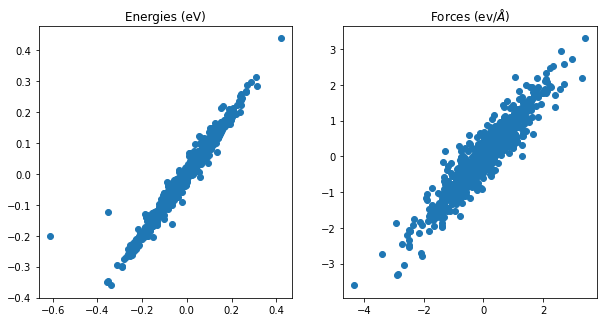

In [41]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((y_val_lammps[:npred] - mlr_lammps.predict(X_val_lammps[:npred]))/np.sum(X_val_lammps[:npred],axis=1),
             (yval_pred[:npred] - mlr_lammps.predict(X_val_lammps[:npred]))/np.sum(X_val_lammps[:npred],axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(fval_true.flatten()[:npred], fval_pred.flatten()[:npred])
p[1].set_title(r'Forces (ev/$\AA$)')

In [42]:
rmse_energy = np.sqrt(np.mean(((yval_true[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [43]:
rmse_forces = np.sqrt(np.mean((fval_true.flatten() - fval_pred.flatten())**2))

In [44]:
print(rmse_energy, rmse_forces)

0.021546736092921796 0.2904718293048525


In [68]:
## Make input files for LAMMPS
struct = 'succinic_beta'
work_dir = f"/exports/commonscratch/vprincip/genMD/PI_NVT_direct_lammps/{struct}/"
xyz_file = f"{work_dir}init.extxyz"

frame = read(xyz_file)
frame.set_pbc(True)
ase.io.write(f"{work_dir}struct.in", frame, format='lammps-data', specorder=['H','C','N','O'])

## Train model on true CSD-1k test set
- Check how the errors are on a model trained only on 9/10ths of the true test set MD structures. 

This is because the training set was created on very diverse (FPS-selected) structures, and so maybe a model trained on more "normal" structures will have more better predictions on more "normal" structures.

In [71]:
#Import data
full_csd_1k = read('raw_data/CSD-1k_md.xyz', ':')

In [72]:
#Get only frames containing HCNO
csd_1k = []
for frm in full_csd_1k:
    X_frm = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    if len(frm) == sum(X_frm):
        csd_1k.append(frm)
print(f"Total number of HCNO structures: {len(csd_1k)}")
print(f"Total number of atoms: {sum([len(frm) for frm in csd_1k])}")

Total number of HCNO structures: 500
Total number of atoms: 63190


In [73]:
#Wrap all atoms in dataset
for frm in csd_1k:
    frm.wrap(eps=1e-13)

### Create train and test sets

In [74]:
#Create train and test sets
ids = np.arange(len(csd_1k))
np.random.seed(34290)
np.random.shuffle(ids)

train_set=[csd_1k[i] for i in ids[:450]]
test_set=[csd_1k[i] for i in ids[450:]]

X_all = np.zeros((len(csd_1k), 4), dtype=int); y_all = np.zeros(len(csd_1k), dtype=float)
for ifrm, frm in enumerate(csd_1k):
    X_all[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm] = frm.info['PBE-D2_energy']

X_train = np.zeros((len(train_set), 4), dtype=int); y_train = np.zeros(len(train_set), dtype=float)
f_train = np.zeros((sum([len(frm) for frm in train_set]),3), dtype=float)

force_counter=0
for ifrm, frm in enumerate(train_set):
    X_train[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_train[ifrm] = frm.info['PBE-D2_energy']
    for iforces, forces in enumerate(frm.arrays['PBE-D2_forces']):
        f_train[force_counter] = forces
        force_counter += 1

force_counter=0
X_test = np.zeros((len(test_set), 4), dtype=int); y_test = np.zeros(len(test_set), dtype=float)
f_test = np.zeros((sum([len(frm) for frm in test_set]),3), dtype=float)
for ifrm, frm in enumerate(test_set):
    X_test[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_test[ifrm] = frm.info['PBE-D2_energy']
    for iforces, forces in enumerate(frm.arrays['PBE-D2_forces']):
        f_test[force_counter] = forces
        force_counter += 1

### Create baselined model

In [75]:
mlr = Ridge(alpha=1e-4, fit_intercept=True)
mlr.fit(X_all, y_all)
print("Intercept: ", mlr.intercept_)
print("Coefficients:",mlr.coef_)

Intercept:  -2.205905716116831
Coefficients: [ -16.30588656 -154.78349229 -383.5558381  -566.45579258]


In [ ]:
#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

### Compute sparse points, Knm

In [76]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [77]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  20.07531213760376 s


In [78]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2000
nc = 2000
nn = 2000
no = 2000
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
The number of pseudo points selected by central atom species is: {1: 2000, 6: 2000, 7: 2000, 8: 2000}
Selecting species: 1
Selecting species: 6
Selecting species: 7
Selecting species: 8
Time taken:  550.2637684345245 s


In [82]:
dump_obj('raw_data/csd-1k_potential/X_sparse.json', X_sparse)

In [14]:
X_sparse = load_obj('raw_data/csd-1k_potential/X_sparse.json')

In [80]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [84]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(train_set, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/450 [00:00<?, ?it/s]

Time taken:  30657.998143672943 s


In [85]:
#Save kernel
np.save('raw_data/csd-1k_potential/Knm_kernel', Knm)

In [15]:
start = time()
print("Loading Knm...")
Knm = np.load('raw_data/csd-1k_potential/Knm_kernel.npy')
print("Knm loading time:", time()-start)

Loading Knm...
Knm loading time: 1779.0270457267761


### Train and test model

In [89]:
#Train GAP model
print("Training GAP model...")
start = time()
model = train_gap_model(kernel, train_set, Knm, X_sparse, y_train, y_dressed, 
                        grad_train=-get_forces(train_set, array_name='PBE-D2_forces'), 
                        lambdas=[0.1,1], jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 135.23339653015137


In [90]:
#Save model
dump_obj('raw_data/csd-1k_potential/GAP_model_0.1_1.json', model)

In [6]:
#Reload model
model = load_obj('raw_data/csd-1k_potential/GAP_model_0.1_1.json')

In [91]:
#predict energies and forces for test set
ytp = []
ftp = []

for ifrm, frm in enumerate(tqdm(test_set, desc = "Making predictions for test set...", leave=False)):
    manager_test = soap.transform(frm)
    ytp.append(model.predict(manager_test))
    ftp.append(model.predict_forces(manager_test))

yt_pred = np.array(ytp).flatten()
ft_pred = np.concatenate(ftp)

Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

In [108]:
np.save('raw_data/csd-1k_potential/yt_pred', yt_pred)
np.save('raw_data/csd-1k_potential/ft_pred', ft_pred)

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

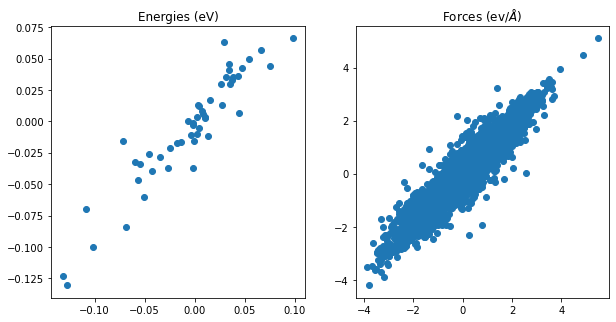

In [92]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1),
             (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(f_test.flatten(), ft_pred.flatten())
p[1].set_title(r'Forces (ev/$\AA$)')

In [93]:
rmse_energy = np.sqrt(np.mean(((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1) 
                              - (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))**2))

In [94]:
rmse_forces = np.sqrt(np.mean((f_test.flatten() - ft_pred.flatten())**2))

In [95]:
print(rmse_energy, rmse_forces)

0.01730346365323473 0.2565681435307788


### Optimise regularisation parameters

In [116]:
ereg_lbound = -3; ereg_hbound = 0; ita = 10
opti_results = np.zeros((len(np.logspace(ereg_lbound, ereg_hbound, ita)),4), dtype=float)

counter=0

for ereg in np.logspace(ereg_lbound, ereg_hbound, ita):
    for freg in [10*ereg, 50*ereg]:
        if counter <10:
            counter += 1
        else:
            print(f"Training model using energy reg {np.round(ereg,5)} and force reg {np.round(freg,5)}")
            model = train_gap_model(kernel, train_set, Knm, X_sparse, y_train, y_dressed, 
                                grad_train=-get_forces(train_set, array_name='PBE-D2_forces'), 
                                lambdas=[ereg,freg], jitter=1e-9, solver = 'RKHS')
            ytp = []
            ftp = []

            for ifrm, frm in enumerate(tqdm(test_set, desc = "Making predictions for test set...", leave=False)):
                manager_test = soap.transform(frm)
                ytp.append(model.predict(manager_test))
                ftp.append(model.predict_forces(manager_test))

            yt_pred = np.array(ytp).flatten()
            ft_pred = np.concatenate(ftp)

            rmse_energy = np.sqrt(np.mean(((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1) 
                                  - (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))**2))
            rmse_forces = np.sqrt(np.mean((f_test.flatten() - ft_pred.flatten())**2))

            opti_results[counter-10] = [ereg, freg, rmse_energy, rmse_forces]

            counter+=1

            print(f"Energy RMSE: {np.round(rmse_energy, 7)}")
            print(f"Forces RMSE: {np.round(rmse_forces, 7)}")
            print("")


Training model using energy reg 0.04642 and force reg 0.46416


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0179324
Forces RMSE: 0.2601525

Training model using energy reg 0.04642 and force reg 2.32079


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0147818
Forces RMSE: 0.2676666

Training model using energy reg 0.1 and force reg 1.0


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0173035
Forces RMSE: 0.2565681

Training model using energy reg 0.1 and force reg 5.0


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0145377
Forces RMSE: 0.2891437

Training model using energy reg 0.21544 and force reg 2.15443


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0173878
Forces RMSE: 0.2603536

Training model using energy reg 0.21544 and force reg 10.77217


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0141114
Forces RMSE: 0.3303732

Training model using energy reg 0.46416 and force reg 4.64159


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0186639
Forces RMSE: 0.2783461

Training model using energy reg 0.46416 and force reg 23.20794


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0140085
Forces RMSE: 0.3949625

Training model using energy reg 1.0 and force reg 10.0


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0198224
Forces RMSE: 0.3158852

Training model using energy reg 1.0 and force reg 50.0


Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Energy RMSE: 0.0137265
Forces RMSE: 0.4782387



In [117]:
np.save('raw_data/csd-1k_potential/opti_results_p2', opti_results)

In [127]:
opti_results_combined = np.zeros((20,4), dtype=float)
opti_1 = np.load('raw_data/csd-1k_potential/opti_results_p1.npy')
opti_2 = np.load('raw_data/csd-1k_potential/opti_results_p2.npy')
opti_results_combined[0:10] = opti_1
opti_results_combined[10:20] = opti_2
opti_results_combined[:, 2:4] *= 1000

In [129]:
pd.DataFrame(opti_results_combined, columns=['Energy Reg.', 'Force Reg.', 'Energy RMSE (meV/atom)', 
                                             'Force RMSE (mev/Ang)'])

,Energy Reg.,Force Reg.,Energy RMSE (meV/atom),Force RMSE (mev/Ang)
0,0.001000,0.010000,18.697988,265.773650
1,0.001000,0.050000,17.190299,270.343340
2,0.002154,0.021544,18.695841,265.754568
3,0.002154,0.107722,17.135889,269.876334
4,0.004642,0.046416,18.685938,265.666946
5,0.004642,0.232079,16.910177,268.144933
6,0.010000,0.100000,18.641220,265.279482
7,0.010000,0.500000,16.246463,264.199689
8,0.021544,0.215443,18.457697,263.803473
9,0.021544,1.077217,15.326252,261.372640


Seems like we can already get very decent results just using 450 training datapoints from the true CSD-1k test set MD structures. Around 15 meV/atom for energies and 260 meV/angstrom when optimising for both energies and forces.

Might be good to look into curating a training set with more "normal" structures...


**However: the fact that forces have lower errors could be because only MD structures were used. As the original model probably wasn't good at predicting near-zero forces for geometry-optimised structures in the validation set, this may have contributed to the increased errors in forces. Therefore, let's make a small model with 450 structures using training set MD structures, and test on the next 50 MD training set strucutres, and see how that model compares with the one we just made.**

## Train model on 450 train set structures
Just to compare to the model above, let's train a model on 450 train set structures, and test on the next 50 train set structures...

In [150]:
n=500
crystals = []; new_set=[]
i=0
for frm in train_set_FPS:
    frm.info['crystal'] = frm.info['name'].split('_')[0]
    if np.mean(np.abs(frm.arrays['forces'])) > 0.05 and i<n: #Make sure you're only using MD frames
        crystals.append(frm.info['crystal'])
        new_set.append(frm)
        i+=1
print(f"Number of unique crystals in new set: {len(np.unique(crystals))}")

Number of unique crystals in new set: 500


However, we should only use MD frames and not geop ones.

In [154]:
avg_forces=[]
for frm in new_set:
    frm.wrap(eps=1e-13)
    avg_forces.append(np.mean(np.abs(frm.arrays['forces'])))
print(f"Minimum average force for a frame: {min(avg_forces)} eV/angstrom")

Minimum average force for a frame: 0.4055839836111111 eV/angstrom


### Create train and test sets

In [155]:
#Create train and test sets
ids = np.arange(len(new_set))
np.random.seed(1543)
np.random.shuffle(ids)

train_set=[new_set[i] for i in ids[:450]]
test_set=[new_set[i] for i in ids[450:]]

X_all = np.zeros((len(new_set), 4), dtype=int); y_all = np.zeros(len(new_set), dtype=float)
for ifrm, frm in enumerate(new_set):
    X_all[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm] = frm.info['energy']

X_train = np.zeros((len(train_set), 4), dtype=int); y_train = np.zeros(len(train_set), dtype=float)
f_train = np.zeros((sum([len(frm) for frm in train_set]),3), dtype=float)

force_counter=0
for ifrm, frm in enumerate(train_set):
    X_train[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_train[ifrm] = frm.info['energy']
    for iforces, forces in enumerate(frm.arrays['forces']):
        f_train[force_counter] = forces
        force_counter += 1

force_counter=0
X_test = np.zeros((len(test_set), 4), dtype=int); y_test = np.zeros(len(test_set), dtype=float)
f_test = np.zeros((sum([len(frm) for frm in test_set]),3), dtype=float)
for ifrm, frm in enumerate(test_set):
    X_test[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_test[ifrm] = frm.info['energy']
    for iforces, forces in enumerate(frm.arrays['forces']):
        f_test[force_counter] = forces
        force_counter += 1

### Create baselined model

In [156]:
mlr = Ridge(alpha=1e-4, fit_intercept=True)
mlr.fit(X_all, y_all)
print("Intercept: ", mlr.intercept_)
print("Coefficients:",mlr.coef_)

Intercept:  -2.694407386930834
Coefficients: [ -16.51485547 -154.67483723 -383.25514219 -566.0576109 ]


In [157]:
#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

### Compute sparse points, Knm

In [158]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

In [159]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  13.496772289276123 s


In [160]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2000
nc = 2000
nn = 2000
no = 2000
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
The number of pseudo points selected by central atom species is: {1: 2000, 6: 2000, 7: 2000, 8: 2000}
Selecting species: 1
Selecting species: 6
Selecting species: 7
Selecting species: 8
Time taken:  332.3391273021698 s


In [164]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [168]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(train_set, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/450 [00:00<?, ?it/s]

Time taken:  9354.62879872322 s


### Train and test model

To compare directly with the CSD-1k model, we will use the regularisers **0.021544** and **1.077217** for energies and forces, respectively. This corresponded to errors of **15.326252 meV/atom** and **261.372640 meV/angstrom** for energies and forces, respectively.

In [169]:
#Train GAP model
print("Training GAP model...")
start = time()
model = train_gap_model(kernel, train_set, Knm, X_sparse, y_train, y_dressed, 
                        grad_train=-get_forces(train_set, array_name='forces'), 
                        lambdas=[ 0.021544,1.077217], jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 95.95209908485413


In [175]:
#Save model
dump_obj('raw_data/csd-1k_potential/SMALL_TRAIN_SET_GAP_model_0.215_1.077.json', model)

In [6]:
#Reload model
model = load_obj('raw_data/csd-1k_potential/SMALL_TRAIN_SET_GAP_model_0.215_1.077.json')

In [170]:
#predict energies and forces for test set
ytp = []
ftp = []

for ifrm, frm in enumerate(tqdm(test_set, desc = "Making predictions for test set...", leave=False)):
    manager_test = soap.transform(frm)
    ytp.append(model.predict(manager_test))
    ftp.append(model.predict_forces(manager_test))

yt_pred = np.array(ytp).flatten()
ft_pred = np.concatenate(ftp)

Making predictions for test set...:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

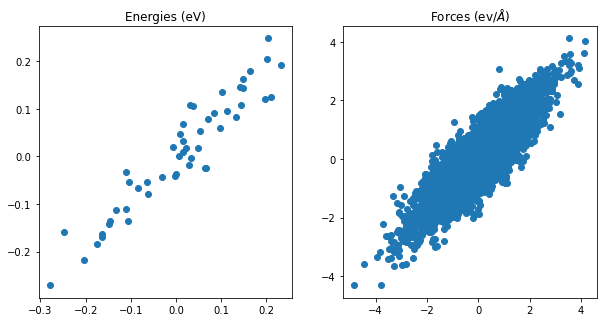

In [171]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1),
             (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(f_test.flatten(), ft_pred.flatten())
p[1].set_title(r'Forces (ev/$\AA$)')

In [172]:
rmse_energy = np.sqrt(np.mean(((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1) 
                              - (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))**2))

In [173]:
rmse_forces = np.sqrt(np.mean((f_test.flatten() - ft_pred.flatten())**2))

In [174]:
print(rmse_energy, rmse_forces)

0.04070142226194922 0.4064031627823195


Quite promissing results!! 

**Energy** RMSE is **40.7** meV/atom cf. **15.3** meV/atom for the test set model.

**Force** RMSE is **406** meV/angstrom cf. **261** meV/angstrom for the test set model.

# BIG PROBLEM

So there appears to be a big issue. There are duplicates (fully - up until the 12th decimal) in energies for 454 frames in the original dataset (i.e. 908 frames that do not have a unique energy). For the energy duplicates, the cells have the exact same cell parameters, but their forces and positions differ. I also checked to see if the labelling of atoms got mixed up (i.e. atom 0 is atom x in the frame with duplicate energy) and this appears not to be the case.

### Check train_set_FPS uniqueness

In [6]:
#Check if train set used throughout these notebooks has duplicate energies
energies_train_FPS = []
for frm in train_set_FPS:
    energies_train_FPS.append(frm.info['energy'])
print(f"{len(np.unique(energies_train_FPS))} out of {len(energies_train_FPS)} frames have unique energies.")

22614 out of 22618 frames have unique energies.


### Check original dataset uniqueness

In [6]:
with open('raw_data/CSD-10k_combined_w_kpts.pickle', 'rb') as f:
    full_dataset = pickle.load(f)

In [7]:
#Check if original dataset has duplicate energies
energies = []
all_frames = []
names = []
for name in full_dataset.keys():
    for ifrm, frm in enumerate(full_dataset[name]):
        energies.append(frm.info['energy'])
        all_frames.append(frm)
        names.append(frm.info['name'])
print(f"{len(np.unique(energies))} out of {len(energies)} frames have unique energies.")

225584 out of 226038 frames have unique energies.


In [283]:
#Get indices of non-unique frames (this will take some time, but is worth checking)
duplicates_indices=[]
for energy in tqdm(energies, leave = False):
    duplicates = np.nonzero(energies == energy)[0]
    if len(duplicates) > 1:
        duplicates_indices.append(duplicates)
#Remove arrays that appear twice (as each duplicate would have been appended twice or more depending on the number of duplicates there were)
u_arrays = []
for arr in duplicates_indices:
    if not any(np.array_equal(arr, u_arr) for u_arr in u_arrays):
        u_arrays.append(arr)
np.save('duplicates_check/original_dataset_duplicates_indices.npy', np.asarray(u_arrays, dtype=object))

  0%|          | 0/226038 [00:00<?, ?it/s]

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


TypeError: The axis argument to unique is not supported for dtype object

In [8]:
#Reload array of indices of duplicates
duplicates_indices = np.load('duplicates_check/original_dataset_duplicates_indices.npy', allow_pickle=True)

In [9]:
non_unique_frames={}
for arr in duplicates_indices:
    name = all_frames[arr[0]].info['name']
    non_unique_frames[name] = [all_frames[i] for i in arr]

In [10]:
print(f"There are {len(duplicates_indices)} non-unique energies in the original dataset")

There are 452 non-unique energies in the original dataset


In [32]:
for key in non_unique_frames.keys():
    print(non_unique_frames[key][1].info['name']+' and '+non_unique_frames[key][0].info['name']
         + ' have energies '+ str(non_unique_frames[key][1].info['energy'])+ ' and '
         + str(non_unique_frames[key][0].info['energy']))
    try:
        print('The equality of positions with a relative threshold of 1e-4 is', 
              np.allclose(non_unique_frames[key][0].get_array('positions'), 
                          non_unique_frames[key][1].get_array('positions'), rtol=1e-4))
    except:
        print('The equality of positions could not be tested. This is likely because there are differing numbers'
             ' of atoms in the two frames (this should be the case for different crystals ONLY.)')

EJIQEU02_88 and EJIQEU02_63 have energies -8476.660262082934 and -8476.660262082934
The equality of positions with a relative threshold of 1e-4 is False
METAMI04_37 and METAMI04_9 have energies -9927.262433366659 and -9927.262433366659
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_79 and XIXQOL_35 have energies -36404.04799055807 and -36404.04799055807
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_93 and XIXQOL_42 have energies -36403.50702824475 and -36403.50702824475
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_59 and XIXQOL_50 have energies -36403.600363291764 and -36403.600363291764
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_77 and XIXQOL_71 have energies -36403.91193363822 and -36403.91193363822
The equality of positions with a relative threshold of 1e-4 is False
COVSEM_99 and COVSEM_66 have energies -14300.603737166466 and -14300.603737166466
The equality of

From above, turns out that two different crystals also have the same energy mapped to them...
Let's for the moment just consider two frames of the same crystal with the same cell parameters.

Let's do some SCF calculations. Let's extract two frames from the same crystal that have very different positions but are mapped to the same energy.

In [12]:
print(full_dataset['REVMIP'][2].info['energy'])
print(full_dataset['REVMIP'][2].get_chemical_formula())
print(full_dataset['IFIJOW'][2].info['energy'])
print(full_dataset['IFIJOW'][2].get_chemical_formula())

-13232.67340827874
C8H32N24O4
-13233.072327167742
C36H46N18


In [13]:
#Define hyperparameters and SOAP
hypers["compute_gradients"] = False
hypers["interaction_cutoff"] = 4
hypers["max_radial"] = 6
hypers["max_angular"] = 4
soap = SphericalInvariants(**hypers)

In [14]:
keys = []
rmses = []
for key in non_unique_frames.keys():
    #Only consider 
    if np.array_equal(non_unique_frames[key][0].cell.cellpar(), non_unique_frames[key][1].cell.cellpar()) is True:
        vecs = []
        for frm in non_unique_frames[key]:
            frm.wrap(eps=1e-13)
            vecs.append(soap.transform(frm).get_features(soap)) 
        rmse = np.sqrt(np.mean((vecs[0] - vecs[1])**2))
        keys.append(key)
        rmses.append(rmse)

In [15]:
for frm in non_unique_frames[keys[rmses.index(max(rmses))]]:
    print(frm.info['name'])
    print(frm.info['energy'])
    print(frm.info['kpts'])

METHOL04_23
-3146.089546280012
[5 5 3]
METHOL04_52
-3146.089546280012
[5 5 3]


We will run SCF calculations for the two configurations above.

In [16]:
for frm in full_dataset['METHOL04']:
    print(frm.info['name'])
    print(frm.info['energy'])
    print("")

METHOL04
-3146.8501316733577

METHOL04_1
-3146.373306592051

METHOL04_2
-3146.4400833283134

METHOL04_3
-3146.4680022082666

METHOL04_4
-3146.2706652517163

METHOL04_5
-3146.429606945485

METHOL04_6
-3146.3578777373405

METHOL04_7
-3146.181248643991

METHOL04_8
-3146.2043238975975

METHOL04_9
-3146.2796994311943

METHOL04_10
-3146.1771397250113

METHOL04_11
-3146.2333856556775

METHOL04_12
-3146.118363135636

METHOL04_13
-3146.005082144169

METHOL04_14
-3146.1045397525795

METHOL04_15
-3146.206772922155

METHOL04_16
-3145.9956670053157

METHOL04_17
-3146.0354500486796

METHOL04_18
-3146.068892839579

METHOL04_19
-3145.9695984994723

METHOL04_20
-3146.080648157454

METHOL04_21
-3146.1478602758593

METHOL04_22
-3146.2041878406776

METHOL04_23
-3146.089546280012

METHOL04_24
-3145.998877948624

METHOL04_25
-3145.9630949787033

METHOL04_26
-3145.981381028731

METHOL04_27
-3146.059858660101

METHOL04_28
-3146.000102460903

METHOL04_29
-3145.9439109530044

METHOL04_30
-3145.933271301872

MET

In [29]:
## Create xyz, extxyz, and dftb files for i-PI simulations using DFTB+. NOTE: if you're automating this process
## for all structures, you will have to change the folder_path argument of this function to the correct path!
def create_geometry_files(frame, folder_path=''):
    cell_array=frame.cell.cellpar() # get cell dimensions
    cell='    '.join(str(a) for a in cell_array.tolist()) #convert cell dimensions to string
    write_xyz(folder_path+'init.xyz', frame, comment='# CELL(abcABC):    '+cell+'  Step:         1  Bead:       0 positions{angstrom}  cell{angstrom}')
    write_extxyz(folder_path+'init.extxyz', frame)
    write_dftb(folder_path+'init.gen', frame)

In [30]:
from os import makedirs
from ase.io.extxyz import write_xyz, write_extxyz
from ase.io.espresso import write_espresso_in

In [31]:
def get_nbnd(frm):
    val_elecs = {'H':1, 'C':4, 'N':5, 'O':6}
    tot_elecs = sum([val_elecs[i] for i in frm.get_chemical_symbols()])
    nbnd = int((tot_elecs/2)*1.2) #equation for getting nbnd from total number of frames
    return nbnd

In [37]:
# Data for pw.x input file -- CHANGE THIS to the parameters used in the curation of your dataset 
input_data = {
    "CONTROL": dict(calculation='scf', # we want to do a structure relaxation
                    pseudo_dir='../../../pseudos/', # change this to your directory of pseudopotentials
                    restart_mode = 'from_scratch',
                    tprnfor = True),
    "SYSTEM": dict(
                   ecutwfc=60.0,
                   ecutrho=240.0,
                   vdw_corr='dft-d',
                   nosym=True),
    "ELECTRONS": dict(conv_thr=1e-10,
                      mixing_beta=0.5,
                      electron_maxstep=300,
                      diagonalization='cg')}

elements = ["H", "C", "N", "O"] # Elements for which you would like to create pair potentials

# Define Pseudopotentials
pseudo_names = ['H.pbe-tm-new-gipaw-dc.UPF', 'C.pbe-tm-new-gipaw-dc.UPF', 
                'N.pbe-n-kjpaw_psl.1.0.0.UPF', 'O.pbe-n-kjpaw_psl.1.0.0.UPF'] #change to the names of your pseudos
pseudopotentials = {i: j for i,j in zip(elements, pseudo_names)}

In [18]:
ase.units.Rydberg * -231.14622620

-3144.9045946019546

In [19]:
ase.units.Rydberg * -231.11226490

-3144.4425275798603

In [27]:
ase.units.Rydberg *  -231.23333400 #METHOL04_52

-3146.0897565877217

In [28]:
ase.units.Rydberg *  -231.23333500 #METHOL04_23

-3146.0897701934146

In [25]:
ase.units.Rydberg* -972.45841355 #energy for IFIJOW_94

-13230.970641876405

In [26]:
ase.units.Rydberg * -972.45841508 #energy for REVMIP_65 in eV

-13230.970662693117

In [132]:
revmip_energy= ase.units.Rydberg * -972.45847483
X_revmip = np.zeros((1,4), dtype=int)
revmip=full_dataset['REVMIP'][65]
print(revmip.info['name'])
symbols = revmip.get_atomic_numbers()
X_revmip[0] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
print(f"Baselined energy: {np.round(revmip_energy-mlr.predict(X_revmip)[0], 8)} eV")

REVMIP_65
Baselined energy: -1.15883031 eV


In [32]:
for key in non_unique_frames.keys():
    print(non_unique_frames[key][1].info['name']+' and '+non_unique_frames[key][0].info['name']
         + ' have energies '+ str(non_unique_frames[key][1].info['energy'])+ ' and '
         + str(non_unique_frames[key][0].info['energy']))
    try:
        print('The equality of positions with a relative threshold of 1e-4 is', 
              np.allclose(non_unique_frames[key][0].get_array('positions'), 
                          non_unique_frames[key][1].get_array('positions'), rtol=1e-4))
    except:
        print('The equality of positions could not be tested. This is likely because there are differing numbers'
             ' of atoms in the two frames (this should be the case for different crystals ONLY.)')

EJIQEU02_88 and EJIQEU02_63 have energies -8476.660262082934 and -8476.660262082934
The equality of positions with a relative threshold of 1e-4 is False
METAMI04_37 and METAMI04_9 have energies -9927.262433366659 and -9927.262433366659
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_79 and XIXQOL_35 have energies -36404.04799055807 and -36404.04799055807
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_93 and XIXQOL_42 have energies -36403.50702824475 and -36403.50702824475
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_59 and XIXQOL_50 have energies -36403.600363291764 and -36403.600363291764
The equality of positions with a relative threshold of 1e-4 is False
XIXQOL_77 and XIXQOL_71 have energies -36403.91193363822 and -36403.91193363822
The equality of positions with a relative threshold of 1e-4 is False
COVSEM_99 and COVSEM_66 have energies -14300.603737166466 and -14300.603737166466
The equality of

In [89]:
#Create xyz files in folders for relax set (change the write_xyz function if you use this for the md set too!)
for frm in full_dataset['METHOL04']:
    name = frm.info['name']
    if name == 'METHOL04_23' or name == 'METHOL04_52':
        makedirs('duplicates_check/data/'+name, exist_ok=True)
        write_xyz('duplicates_check/data/'+name+'/'+name+'.xyz', frm)
        input_data["SYSTEM"]["nbnd"] = get_nbnd(frm)
        write('duplicates_check/data/'+name+'/'+name+'.espresso.in', frm, format='espresso-in', 
              input_data=input_data, pseudopotentials=pseudopotentials) #gamma-point only

In [36]:
for frm in full_dataset['WOLNOC']:
    name = frm.info['name']
    if name == 'WOLNOC_89' or name=='GLUTAM09_99':
        makedirs('duplicates_check/data/'+name, exist_ok=True)
        write_xyz('duplicates_check/data/'+name+'/'+name+'.xyz', frm)
        input_data["SYSTEM"]["nbnd"] = get_nbnd(frm)
        write('duplicates_check/data/'+name+'/'+name+'.espresso.in', frm, format='espresso-in', 
              kpts=frm.info['kpts'], input_data=input_data, pseudopotentials=pseudopotentials)

### Check Aditi's dataset
Check if Aditi's dataset contains unique energies, and if any energies in her dataset correspond to non-unique energies in the original dataset.

In [194]:
aditi_dataset = read('raw_data/CSD-10k-hcno_4_md_1_geop_subselection_w_dftb.xyz', ':')

In [257]:
energies_train = []
for frm in aditi_dataset:
    energies_train.append(frm.info['DFT_energy'])
print(f"{len(np.unique(energies_train))} out of {len(energies_train)} frames have unique energies.")

11190 out of 11190 frames have unique energies.


From above, it appears that the dataset Aditi used does not contain any duplicate energies. However, the frames she did use might originate from a duplicate in the original dataset, meaning that likely the energy and/or forces attributed to that frame are incorrect.

In [255]:
#Get indices of frames in full dataset that correspond to an energy in Aditi's dataset,
# ONLY if more than one frame in the original dataset is matched
# I.e. find which frames of Aditi's originate from a frame with a 'duplicate' energy
nz_indices = []
for frm in tqdm(aditi_dataset, leave=False):
    if len(np.nonzero(energies == frm.info['DFT_energy'])[0]) > 1:
        nz_indices.extend(np.nonzero(energies == frm.info['DFT_energy']))
print(f"Found {len(nz_indices)} frames that originate from a duplicate.")

  0%|          | 0/11190 [00:00<?, ?it/s]

Found 44 frames that originate from a duplicate.


In [240]:
#Check if positions, forces and energies of duplicates are equal
for inds in nz_indices:
    print(f"Duplicates  {i} :")
    for ind in inds:
        print(f"Energy: {all_frames[ind].info['energy']}")
        print(f"Position (atom 0): {all_frames[ind].get_positions()[0]}")
        print(f"Force (atom 0): {all_frames[ind].get_array('forces')[0]}")
        print(f"Cell: {all_frames[ind].cell.cellpar()}")
        print()
    print("")

Duplicates  1 :
Energy: -36403.600363291764
Position (atom 0): [ 0.0727625 -0.122189   1.63255  ]
Force (atom 0): [0.8367501  0.42186404 1.16173754]
Cell: [12.0015 17.6425  4.5555 90.     90.     90.    ]

Energy: -36403.600363291764
Position (atom 0): [ 0.0700572 -0.078693   1.76939  ]
Force (atom 0): [-0.95346275 -0.94057639  0.1446225 ]
Cell: [12.0015 17.6425  4.5555 90.     90.     90.    ]


Duplicates  2 :
Energy: -8919.005798760856
Position (atom 0): [0.936449 2.87711  0.261702]
Force (atom 0): [ 3.2673939  -1.56229484  0.55597021]
Cell: [10.601  3.647 10.008 90.    90.    90.   ]

Energy: -8919.005798760856
Position (atom 0): [1.03775  2.87369  0.284816]
Force (atom 0): [ 0.46330816  0.11447477 -0.80207106]
Cell: [10.601  3.647 10.008 90.    90.    90.   ]


Duplicates  3 :
Energy: -4553.054263294398
Position (atom 0): [-1.03334  3.25272  5.98839]
Force (atom 0): [0.82332894 0.17965429 0.30461608]
Cell: [  8.227   8.769   8.92  112.535  93.38  103.536]

Energy: -4553.0542632943

In [254]:
#Check if atoms got mixed up
indices = nz_indices[0]
tolerance = 1e-3
n = 0
for pos in all_frames[indices[0]].get_positions():
    for pos2 in all_frames[indices[1]].get_positions():
        if np.allclose(pos, pos2, rtol = tolerance) == True:
            n += 1
print(f"Found {n} atoms that are equal in position using a tolerance of {tolerance}.")

Found 0 atoms that are equal in position using a tolerance of 0.001.


### Check original MD dataset

In [316]:
#Check in very original MD dataset, before any procesing was done
md_dataset = read('raw_data/CSD-10k_md_hcno_w_kpts.xyz', ':')

In [317]:
energies_md = []
for frm in md_dataset:
    energies_md.append(frm.info['energy'])
print(f"{len(np.unique(energies_md))} out of {len(energies_md)} are unique.")

225685 out of 226139 are unique.
